# EMG / Differential Electrode Data Analysis

### Workflow

1. Isolate EMG signals from dataset
2. Inspect data manually for all observations
3. Devise relevant features
4. Analyze clustering performance with PCA

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from data_operations import load_data, body_movement_code
import scipy.stats
import scipy.signal
import numpy as np
import scipy.stats
from feature_extraction import (
    peak_z_score,
    spectral_entropy,
    mean_crossings,
    process_dataframe,
    FeatureExtractor,
    peak_frequency
)
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D


In [7]:
dataset = load_data()
dataset

Trimming observations to 967 samples


time_ms       ch0       ch1  ch0_hp  ch1_hp  \
body_label rep sample_num                                                    
0          1   0.0         1514824.503  12535249  12566283  -11889   17295   
               1.0         1514827.496  12536264  12559246   -2063   13384   
               2.0         1514830.493  12538584  12565279    2757   16008   
               3.0         1514833.500  12546745  12567024    7504    5644   
               4.0         1514836.498  12537375  12545467   -3855  -15893   
...                                ...       ...       ...     ...     ...   
4          3   962.0       1618110.457  12136089  12370189  -31898   45780   
               963.0       1618113.448  12165574  12340495   20709    2953   
               964.0       1618116.437  12200077  12301532   45799  -36427   
               965.0       1618119.442  12153545  12317293  -14411   -3002   
               966.0       1618122.435  12099585  12324114  -50651   13979   

                                 qx        qy        qz        qw          gx  \
body_label rep sample_num                                                       
0          1   0.0         0.321960 -0.596619 -0.621826  0.392090   -1.342870   
               1.0         0.321960 -0.596741 -0.621826  0.392029   -1.510729   
               2.0         0.321960 -0.596741 -0.621765  0.391968   -1.230964   
               3.0         0.321960 -0.596741 -0.621765  0.391968   -1.230964   
               4.0         0.321960 -0.596802 -0.621765  0.391907   -1.063105   
...                             ...       ...       ...       ...         ...   
4          3   962.0      -0.749451 -0.095520 -0.654175  0.034607 -167.187300   
               963.0      -0.749451 -0.095520 -0.654175  0.034607 -167.187300   
               964.0      -0.725403 -0.101318 -0.679504  0.041626 -168.474210   
               965.0      -0.725403 -0.101318 -0.679504  0.041626 -168.474210   
               966.0      -0.698059 -0.106567 -0.706360  0.049316 -169.984940   

                                   gy         gz         ax         az  \
body_label rep sample_num                                                
0          1   0.0           1.063105   0.503576  -0.660156 -10.003906   
               1.0           1.175011   0.000000  -0.660156 -10.003906   
               2.0           1.175011  -0.279765  -0.660156 -10.003906   
               3.0           1.175011  -0.279765  -0.660156 -10.003906   
               4.0           0.839294  -0.727388  -0.660156 -10.003906   
...                               ...        ...        ...        ...   
4          3   962.0      -729.625900 -75.424520 -15.074219  -1.500000   
               963.0      -729.625900 -75.424520 -15.074219  -1.500000   
               964.0      -807.568360 -64.513700 -15.074219  -1.500000   
               965.0      -807.568360 -64.513700 -15.074219  -1.500000   
               966.0      -887.133360 -53.043358 -15.074219  -1.500000   

                                 ay  emg_raw  emg_hp  
body_label rep sample_num                             
0          1   0.0          1.21875    31034   29184  
               1.0          1.21875    22982   15447  
               2.0          1.21875    26695   13251  
               3.0          1.21875    20279   -1860  
               4.0          1.21875     8092  -12038  
...                             ...      ...     ...  
4          3   962.0      -11.37500   234100   77678  
               963.0      -11.37500   174921  -17756  
               964.0      -11.37500   101455  -82226  
               965.0      -11.37500   163748   11409  
               966.0      -11.37500   224529   64630  

[14505 rows x 17 columns]

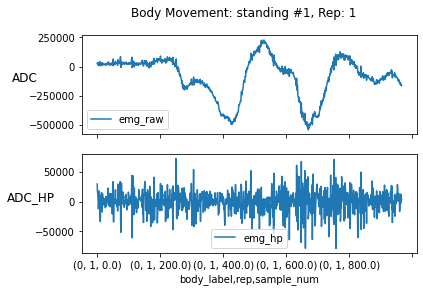

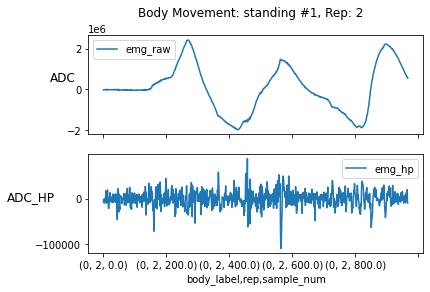

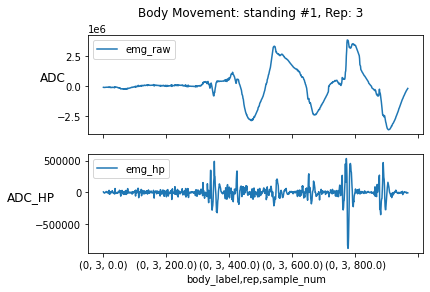

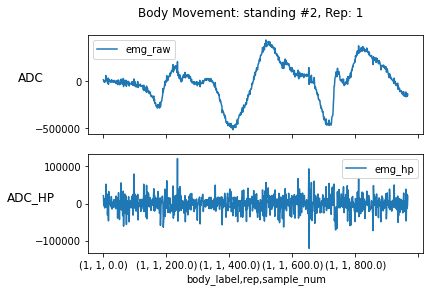

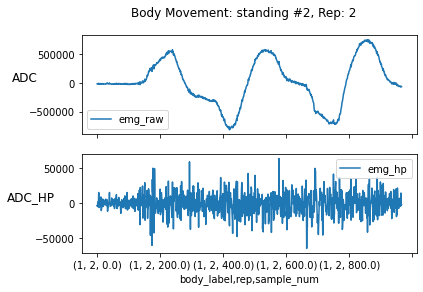

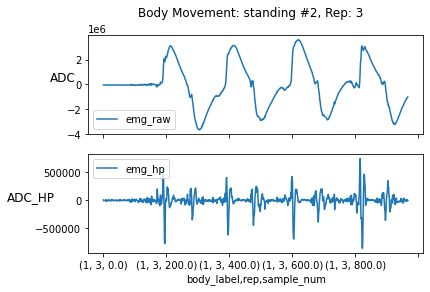

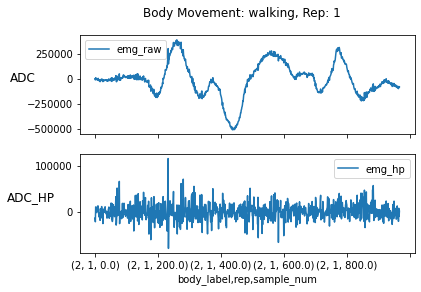

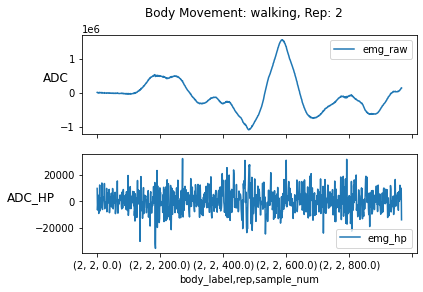

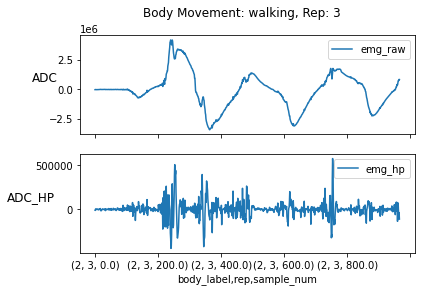

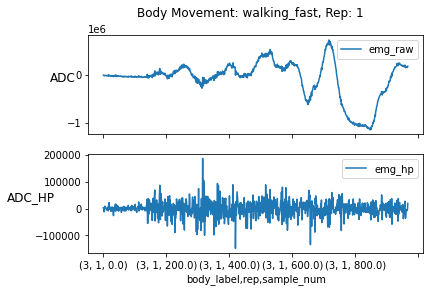

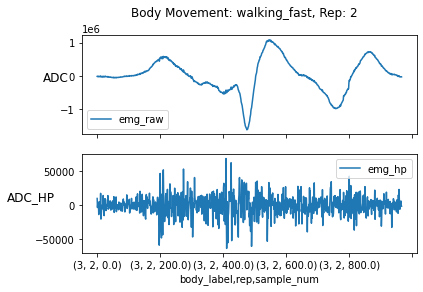

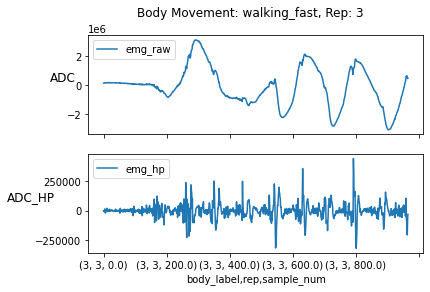

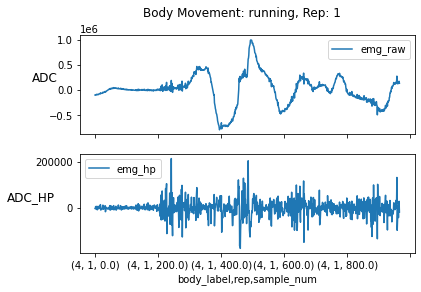

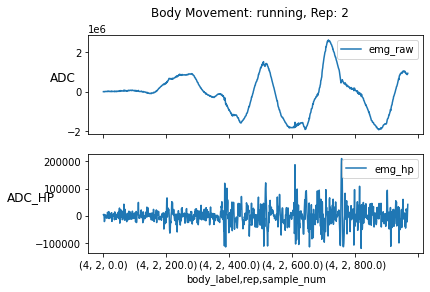

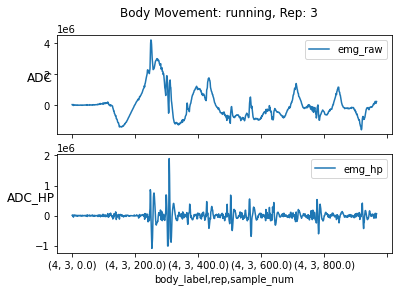

In [8]:
data_groups = [['emg_raw'], ['emg_hp']]
sensors = ['ADC', 'ADC_HP']

for (body, rep), observation in dataset.groupby(level=(0,1)):
    fig, axes = plt.subplots(nrows=len(data_groups), ncols=1, sharex=True)
    fig.suptitle(f'Body Movement: {body_movement_code[body]}, Rep: {rep}')
    for group_idx, data_group in enumerate(data_groups):
        axes[group_idx].set_ylabel(sensors[group_idx], rotation=0, size='large')
        observation.plot(y=data_group, ax=axes[group_idx], use_index=True)

plt.show()

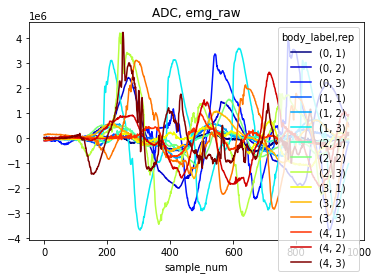

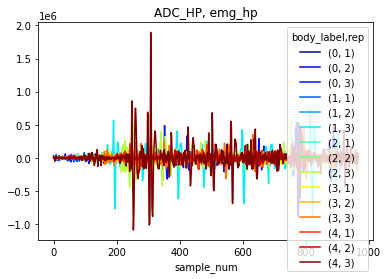

In [9]:
for sensor, data_group in zip(sensors, data_groups):
    for i, channel in enumerate(data_group):
        dataset[channel].unstack((0, 1)).plot(title=f'{sensor}, {channel}', use_index=True, colormap='jet')


## Notable Features

### Inspected Classes

There appear to be 3 classes in this data, as identified by looking at the standing observations:

- In the first standing repetition, the magnitude of the raw data is relatively low and the spectra of the high passed information is relatively smooth and featureless.

- The second standing repetition's raw data shows greater amplitude with a smoother transitions from positive to negative, but still has a relatively featureless high passed signal.

- The thrid standing repetition's raw data varies much quicker and the high passed data shows sharp, impulsive events throughout.

These three classes can be separated somewhat easily using simple time and frequency domain statistics.

### Frequency Domain 
When considering high passed data, some repetitions have much more impulsiveness than others, implying a higher bandwidth over all.  This is clear when comparing the standing set 1 repetitions 1 and 3.  A great feature for capturing spectral distribution would be spectral entropy.  Spectral entropy involves converting a power spectrum estimate to a probability distribution, then taking the entropy of that distribution.

### Time Domain Statistics
When veiwed across all observations, the raw data doesn't seem to vary much in amplitude as body motion increases, so developing stats like segmented means, variances, maxes, mins, and mean crossing counts may capture meaningful differences in the dataset.

High passed data would almost certainly benefit from global statistics like variance and maximum amplitude as well as segmented variances to capture transient activity.  Some gestures have very impulsive high passed data, especially the first two standing data sets' third repetition.  A good feature to capture sharp impulses in time would be the number of standard deviations above the median, or a slightly modified z-score.

Relevant durations for segmentation seem to be in the 100 millisecond range for high passed data as impulses trains in some observations are periodic in this duration.

In [26]:
# EMG Features
extractors = {}
extractors.update(
    {
        "emg_raw": [
            FeatureExtractor("min_max", lambda x: np.max(x) - np.min(x)),
            FeatureExtractor("rms", lambda x: np.sqrt(np.sum(x ** 2))),
        ],
        "emg_hp": [
            FeatureExtractor("absmax", lambda x: np.max(np.abs(x)), segment_length=200),
            FeatureExtractor("rms", lambda x: np.sqrt(np.sum(x ** 2))),
            FeatureExtractor("peak_f", peak_frequency),
            FeatureExtractor("spec_entropy", spectral_entropy(256, int(256 * 0.8))),
        ],
    }
)

results = process_dataframe(dataset, extractors)
results

emg_raw.min_max  emg_raw.rms  emg_hp.absmax.0.200  \
body_label rep                                                      
0.0        1.0        -1.167758    -1.087015            -0.335725   
           2.0         0.248565     0.659467            -0.277940   
           3.0         1.467714     1.255982            -0.177190   
1.0        1.0        -1.097477    -1.065849            -0.232162   
           2.0        -0.860929    -0.725752            -0.336958   
           3.0         1.351613     1.773152             3.560660   
2.0        1.0        -1.117667    -1.126200            -0.304192   
           2.0        -0.442040    -0.494840            -0.473396   
           3.0         1.500976     1.292990             0.011654   
3.0        1.0        -0.740936    -0.713983            -0.193031   
           2.0        -0.422480    -0.527136            -0.344980   
           3.0         0.939583     1.002620             0.008304   
4.0        1.0        -0.772720    -0.894652            -0.547032   
           2.0         0.308828     0.392099            -0.398620   
           3.0         0.804729     0.259117             0.040609   

                emg_hp.absmax.200.400  emg_hp.absmax.400.600  \
body_label rep                                                 
0.0        1.0              -0.522345              -0.788360   
           2.0              -0.550782              -0.486717   
           3.0               0.355674               0.748940   
1.0        1.0              -0.418143              -0.736370   
           2.0              -0.548101              -0.728580   
           3.0               0.627631               1.332542   
2.0        1.0              -0.428919              -0.718148   
           2.0              -0.605364              -0.909292   
           3.0               0.396105               0.360248   
3.0        1.0              -0.280892              -0.270431   
           2.0              -0.561832              -0.705737   
           3.0              -0.146206               0.625040   
4.0        1.0              -0.223439               0.029614   
           2.0              -0.421622              -0.421011   
           3.0               3.328236               2.668261   

                emg_hp.absmax.600.800  emg_hp.rms  emg_hp.peak_f  \
body_label rep                                                     
0.0        1.0              -0.687013   -0.644400       0.398549   
           2.0              -0.793243   -0.659878       0.398549   
           3.0               2.130843    1.011411      -1.071994   
1.0        1.0              -0.539334   -0.579108       1.846923   
           2.0              -0.734725   -0.698381       0.398549   
           3.0               1.463324    1.399710      -1.101552   
2.0        1.0              -0.821112   -0.659993       0.391159   
           2.0              -0.850692   -0.827022       0.391159   
           3.0               1.063607    0.670685      -1.071994   
3.0        1.0              -0.489348   -0.451314       0.398549   
           2.0              -0.823928   -0.712841       0.398549   
           3.0               0.581397    0.210261      -1.094163   
4.0        1.0              -0.440788   -0.331487       1.684350   
           2.0              -0.223653   -0.334700      -1.049825   
           3.0               1.164666    2.607058      -0.916811   

                emg_hp.spec_entropy  
body_label rep                       
0.0        1.0             0.750544  
           2.0             0.389636  
           3.0            -1.774153  
1.0        1.0             0.823204  
           2.0             0.782419  
           3.0            -1.717629  
2.0        1.0             0.832356  
           2.0             0.272894  
           3.0            -0.285081  
3.0        1.0             0.832842  
           2.0             0.648286  
           3.0            -0.838855  
4.0        1.0             0.635290  
           2.0            

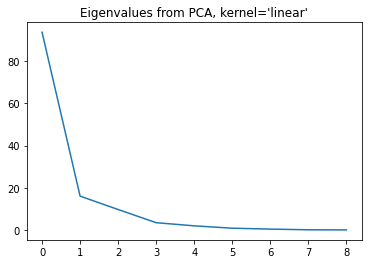

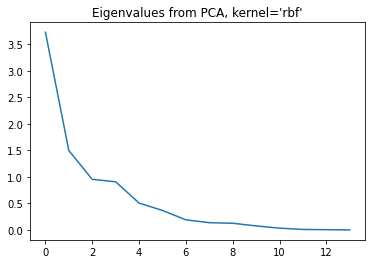

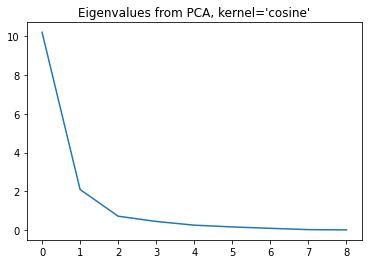

In [27]:
# Cluster with PCA

# Color repetitions to see pattern in clusters
color_map = {0: 'g', 1: 'b', 2: 'r'}

pca_outputs = {}
for kernel in ['linear', 'rbf', 'cosine']:
    pca = KernelPCA(kernel=kernel)
    pca.fit(results)
    plt.figure()
    plt.plot(pca.eigenvalues_)
    plt.title(f'Eigenvalues from PCA, {kernel=}')
    pca_outputs[kernel] = pd.DataFrame(data=pca.transform(results), index=results.index)


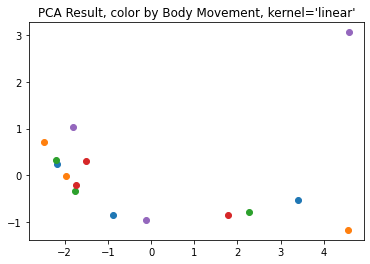

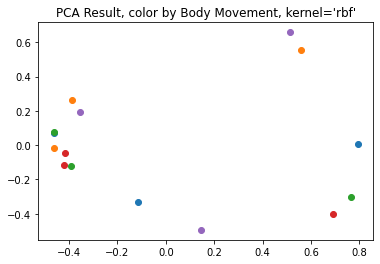

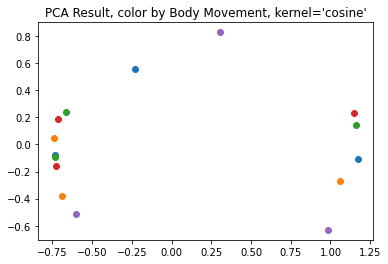

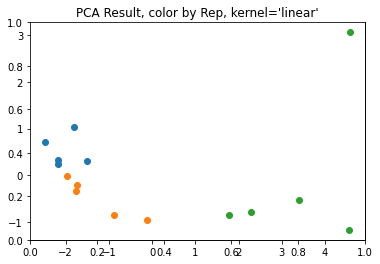

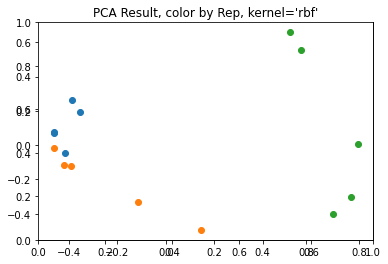

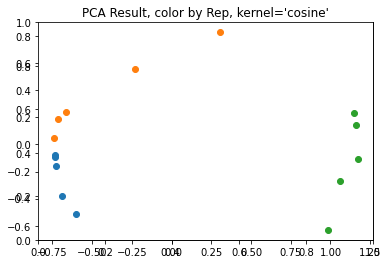

In [28]:
# Color clusters by body for each kernel
for kernel, frame in pca_outputs.items():
    plt.figure()
    plt.title(f'PCA Result, color by Body Movement, {kernel=}')
    for _, subframe in frame.groupby(level=0):
        plt.scatter(subframe.values[:, 0], subframe.values[:, 1])
    plt.show()

# Color clusters by rep for each kernel
for kernel, frame in pca_outputs.items():
    plt.figure()
    plt.title(f'PCA Result, color by Rep, {kernel=}')
    ax = plt.axes()
    for _, subframe in frame.groupby(level=1):
        plt.scatter(subframe.values[:, 0], subframe.values[:, 1])
    plt.show()



### PCA Analysis

There is a large amount of explained variance in the first few components of each kernel run, indicating that feature extraction has picked up on some meaningful trends in the data. We can also see that we have not clustered, and therefore will not classify, based on movement category.  As expected from inspection, repetition is highly correlated with clustering.  While clustering isn't necessarily neat for any kernel, adding dynamics information should give much more information.